## Darknet53 using Tensorflow 2.0

Implemented Darknet53 using Keras Functional API and subclass layers. It is necessary to test and understand the backbone network of YOLO v3. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Conv Block and Darknet Block

These blocks are main components of Darknet. Implemented these as subclass of tensorflow.keras.layers.Layer.

To learn more about layers and models for Tensorflow 2.0, please refer [this guide](https://www.tensorflow.org/alpha/guide/keras/custom_layers_and_models).

In [2]:
class ConvBlock(layers.Layer):
    
    def __init__(self, num_filters, kernel_size, strides=1, data_format='channels_last'):
        
        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.strides = strides
        self.data_format = data_format
        
        self.conv = layers.Conv2D(num_filters,
                                            kernel_size,
                                            strides,
                                            padding = ('same' if strides == 1 else 'valid'), 
                                            data_format=data_format, 
                                            use_bias=False)
        self.batchnorm = layers.BatchNormalization(
                            axis = -1 if data_format == "channels_last" else 1,
                            momentum=0.99,
                            #epsilon=0.01)
                            epsilon=1e-05)
        self.leaky_relu = layers.LeakyReLU(alpha=0.1)

    def call(self, x, training=False):
        
        if self.strides > 1:
            x = self._fixed_padding(x, self.kernel_size)
            
        output = self.conv(x)
        output = self.batchnorm(output, training=training)
        output = self.leaky_relu(output)
        
        return output
    
    def _fixed_padding(self, inputs, kernel_size, mode='CONSTANT'):
        pad_total = kernel_size - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg

        if self.data_format == 'channels_first':
            padded_inputs = tf.pad(tensor=inputs, paddings=[[0, 0], [0, 0], [pad_beg, pad_end], [pad_beg, pad_end]], mode=mode)
        else:
            padded_inputs = tf.pad(tensor=inputs, paddings=[[0, 0], [pad_beg, pad_end], [pad_beg, pad_end], [0, 0]], mode=mode)

        return padded_inputs    

In [3]:
class DarknetBlock(layers.Layer):
    
    def __init__(self, num_filters, data_format='channels_last'):
        
        super(DarknetBlock, self).__init__()

        self.conv1 = ConvBlock(num_filters, 1, data_format=data_format)
        self.conv2 = ConvBlock(num_filters*2, 3, data_format=data_format)
        self.add = layers.Add()
    
    def call(self, x, training=False):

        shortcut = x
        output = self.conv1(x,training=training)
        output = self.conv2(output,training=training)        
        output = self.add([output, shortcut])
            
        return output

### Darknet53 using Keras Functional API

Using Conv and Darknet blocks above, I implemented Darknet53 based on Tensorflow 2.0 Keras Functional API. I refered the [cfg file](https://github.com/pjreddie/darknet/blob/master/cfg/darknet53.cfg) available in Darknet website.

### Tensorflow 2.0 - Keras Functional API

Keras funcitonal API is a more flexible method to create models. It is easy to debug step by step.

[More explanation and example code](https://www.tensorflow.org/alpha/guide/keras/functional)

In [4]:
inputs = tf.keras.Input(shape=(256,256,3), name='img')
output = ConvBlock(32,3,strides=1)(inputs)
output = ConvBlock(64,3,strides=2)(output)

output = DarknetBlock(32)(output)

output = ConvBlock(128,3,strides=2)(output)
for _ in range(2):
    output = DarknetBlock(64)(output)

output = ConvBlock(256,3,strides=2)(output)
for _ in range(8):
    output = DarknetBlock(128)(output)

output = ConvBlock(512,3,strides=2)(output)
for _ in range(8):
    output = DarknetBlock(256)(output)

output = ConvBlock(1024,3,strides=2)(output)  
for _ in range(4):
    output = DarknetBlock(512)(output)

output = layers.GlobalAvgPool2D()(output)
output = layers.Reshape((1,1,1024))(output)
output = layers.Conv2D(1000,1)(output)

In [5]:
model = tf.keras.Model(inputs=inputs, outputs=output)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv_block (ConvBlock)       (None, 256, 256, 32)      992       
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 128, 128, 64)      18688     
_________________________________________________________________
darknet_block (DarknetBlock) (None, 128, 128, 64)      20864     
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 64, 64, 128)       74240     
_________________________________________________________________
darknet_block_1 (DarknetBloc (None, 64, 64, 128)       82688     
_________________________________________________________________
darknet_block_2 (DarknetBloc (None, 64, 64, 128)       82688 

## Load Darknet53 weights

[Imagenet weights of Darknet53](https://pjreddie.com/media/files/darknet53.weights) are available in Darknet website. We will read this weight file using numpy. I changed this load weight function for Tensorflow 2.0 variables list.

In [7]:
def load_weights(model, weights_file):
    """
    Loads and converts pre-trained weights.
    :param model: Keras model
    :param weights_file: name of the binary file.
    :return total_params: if load successfully end else -1
    """
                               
    with open(weights_file, "rb") as fp:
        _ = np.fromfile(fp, dtype=np.int32, count=5)

        weights = np.fromfile(fp, dtype=np.float32)
    

    ptr = 0
    i = 0
    total_params = 0

    var_list = model.variables
    
    var_name_list = ['/'.join(x.name.split('/')[:-1]) for x in var_list]

    print(len(model.variables))
    print(len(model.trainable_variables))
    
    assert len(var_list) - 105 != len(model.trainable_variables), 'list length is wrong'

    while i < len(model.trainable_variables):
        var1 = var_list[i]
        var2 = var_list[i + 1]

        print("%d - var1 : %s (%s)" %(i, var1.name.split('/')[-2], var1.name.split('/')[-1]))
        print("%d - var2 : %s (%s)" %(i, var2.name.split('/')[-2], var2.name.split('/')[-1]))        
        
        # do something only if we process conv layer        
        if 'conv2' in var1.name.split('/')[-2]:
            # check type of next layer
            if 'batch_normalization' in var2.name.split('/')[-2]:
                
                # load batch norm's gamma and beta params
                # beta bias
                # gamma kernel                
                gamma, beta = var_list[i + 1:i + 3]
                
                # Find mean and variance of the same name  
                layer_name = '/'.join(gamma.name.split('/')[:-1])
                mean_index = i + 3
                mean_index += var_name_list[i+3:].index(layer_name)
                mean, var = var_list[mean_index:mean_index+2] 

                batch_norm_vars = [beta, gamma, mean, var]
                
                for batch_norm_var in batch_norm_vars:
                    shape = batch_norm_var.shape.as_list()
                    num_params = np.prod(shape)
                    batch_norm_var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                  
                    batch_norm_var.assign(batch_norm_var_weights, name=batch_norm_var.name)
                    #assign_ops.append(
                    #    tf.compat.v1.assign(var, var_weights, validate_shape=True))

                # we move the pointer by 4, because we loaded 4 variables
                i += 2
            elif 'conv2' in var2.name.split('/')[-2]:
                # load biases
                print("%d - var2 : %s" %(i, var2.name.split('/')[-2]))
                bias = var2
                bias_shape = bias.shape.as_list()
                bias_params = np.prod(bias_shape)
                bias_weights = weights[ptr:ptr +
                                       bias_params].reshape(bias_shape)
                ptr += bias_params

                bias.assign(bias_weights, name=bias.name)

                # we loaded 1 variable
                i += 1
            # we can load weights of conv layer
            shape = var1.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
        
            # remember to transpose to column-major
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            var1.assign(var_weights, name=var1.name)
            i += 1
            
        total_params = ptr
            
    
    
    return total_params if total_params == weights.shape else -1

In [8]:
load_weights(model, './darknet53.weights')

262
158
0 - var1 : conv2d (kernel:0)
0 - var2 : batch_normalization_v2 (gamma:0)
3 - var1 : conv2d_1 (kernel:0)
3 - var2 : batch_normalization_v2_1 (gamma:0)
6 - var1 : conv2d_2 (kernel:0)
6 - var2 : batch_normalization_v2_2 (gamma:0)
9 - var1 : conv2d_3 (kernel:0)
9 - var2 : batch_normalization_v2_3 (gamma:0)
12 - var1 : conv2d_4 (kernel:0)
12 - var2 : batch_normalization_v2_4 (gamma:0)
15 - var1 : conv2d_5 (kernel:0)
15 - var2 : batch_normalization_v2_5 (gamma:0)
18 - var1 : conv2d_6 (kernel:0)
18 - var2 : batch_normalization_v2_6 (gamma:0)
21 - var1 : conv2d_7 (kernel:0)
21 - var2 : batch_normalization_v2_7 (gamma:0)
24 - var1 : conv2d_8 (kernel:0)
24 - var2 : batch_normalization_v2_8 (gamma:0)
27 - var1 : conv2d_9 (kernel:0)
27 - var2 : batch_normalization_v2_9 (gamma:0)
30 - var1 : conv2d_10 (kernel:0)
30 - var2 : batch_normalization_v2_10 (gamma:0)
33 - var1 : conv2d_11 (kernel:0)
33 - var2 : batch_normalization_v2_11 (gamma:0)
36 - var1 : conv2d_12 (kernel:0)
36 - var2 : batch_n

41645640

In [9]:
# check weights successfully loaded
#model.variables[:10]

## ImageNet Class Label

Darknet uses its own Imagenet label list according to [its code](https://github.com/pjreddie/darknet/blob/61c9d02ec461e30d55762ec7669d6a1d3c356fb2/examples/classifier.c#L573). I downloaded the list from [here](https://raw.githubusercontent.com/pjreddie/darknet/master/data/imagenet.shortnames.list).

In [10]:
with open('./imagenet.shortnames.list') as f:
    lineList = f.readlines()
    idx2label=[line.rstrip() for line in lineList]

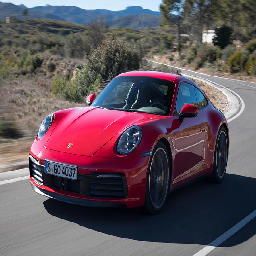

In [11]:
from PIL import Image

img_resized = Image.open('./img_data/911-road.jpg').resize((256,256))
img_resized

In [12]:
img_resized = np.asarray(img_resized)
img_resized = img_resized/255.0
img_resized = img_resized.astype(np.float32)

In [13]:
imagenet = model.predict(img_resized[np.newaxis, ...])

In [14]:
prob, label_index = tf.nn.top_k(tf.reshape(imagenet, shape=[-1]), k=5, sorted=True)
prob = tf.nn.softmax(prob).numpy()

In [15]:
for i, index in enumerate(label_index.numpy()):
    print('{:3.2f}% : {}'.format(prob[i]*100, idx2label[index]))

78.28% : sports car
13.81% : racer
2.94% : car wheel
2.63% : grille
2.33% : convertible


The results shows the similar results with original Darknet53.

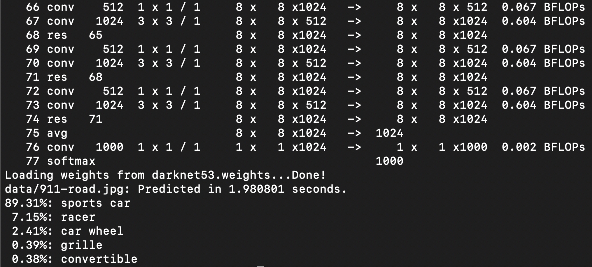

In [16]:
darknet_result = Image.open('./DarknetResult.jpg').resize((592,267))
darknet_result